# MIA vs Overfitting

In this notebook we will study the effect of overfitting in MIA's performance, given a CNN model, CIFAR-10 dataset and a MIA framework that will perfrom the attacks for us.

In [78]:
import numpy as np
import matplotlib.pyplot as plt

import math
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import regularizers

# for image interpolation
import scipy.ndimage.interpolation as interpolation

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

from mia_v2.attack_model import *
from mia_v2.label_only import *
from mia_v2.shadow_models import *
from mia_v2.utilities import *
from mia_v2.wrappers import ConfidenceVectorAttack, LabelOnlyAttack

from tqdm.notebook import tqdm
import sys
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [79]:
def f_target(X_train, y_train, epochs=100):
  """
  Returns a trained target model, if test data are specified we will evaluate the model and print its accuracy
  """
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='tanh'))


  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.Adam()

  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1e-3, patience=3)
  history = model.fit(X_train, y_train, 
                      epochs=epochs, 
                      validation_split=0.2,
                      callbacks=[es]
                      )
  return model, history

In [80]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images = train_images/255
test_images = test_images/255

In [81]:
print(f"We have {len(train_images)} train instances and {len(test_images)} test instances.")

We have 50000 train instances and 10000 test instances.


Let us give the attacker 10000 data points and let the rest of them be training-evaluation-testing datapoints for the target model.

In [82]:
attacker_images, attacker_labels = (test_images, test_labels)
N_SHADOWS = 20
D_SHADOW= attacker_images.shape[0]//N_SHADOWS

In [83]:
def f_shadow():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='tanh'))


  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.Adam()

  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

In [84]:
attack = ConfidenceVectorAttack(None, (train_images, train_labels), 
                                  (attacker_images, attacker_labels), shadow_creator=f_shadow, attack_model_creator=cifar_10_f_attack_builder,
                                n_shadows=N_SHADOWS, D_shadow_size=D_SHADOW, verbose=True)
attack.perform_attack()

Epoch 1/25
11/11 [==============================] - 1s 33ms/step - loss: 2.4255 - accuracy: 0.1134 - val_loss: 2.2810 - val_accuracy: 0.1818
Epoch 2/25
11/11 [==============================] - 0s 18ms/step - loss: 2.0541 - accuracy: 0.3075 - val_loss: 2.1164 - val_accuracy: 0.2182
Epoch 3/25
11/11 [==============================] - 0s 12ms/step - loss: 1.7354 - accuracy: 0.4299 - val_loss: 2.0553 - val_accuracy: 0.2606
Epoch 4/25
11/11 [==============================] - 0s 13ms/step - loss: 1.4085 - accuracy: 0.5672 - val_loss: 2.0796 - val_accuracy: 0.2848
Epoch 5/25
11/11 [==============================] - 0s 16ms/step - loss: 1.1457 - accuracy: 0.6448 - val_loss: 2.2490 - val_accuracy: 0.2242
Epoch 6/25
11/11 [==============================] - 0s 16ms/step - loss: 1.0064 - accuracy: 0.6955 - val_loss: 2.2365 - val_accuracy: 0.2667
Epoch 7/25
11/11 [==============================] - 0s 12ms/step - loss: 0.7692 - accuracy: 0.7851 - val_loss: 2.3751 - val_accuracy: 0.2909
Epoch 8/25
11

Epoch 1/100
1250/1250 [==============================] - 12s 9ms/step - loss: 1.4391 - accuracy: 0.4933 - val_loss: 1.2137 - val_accuracy: 0.5743
Epoch 2/100
1250/1250 [==============================] - 11s 9ms/step - loss: 1.1018 - accuracy: 0.6184 - val_loss: 1.1337 - val_accuracy: 0.6117
Epoch 3/100
1250/1250 [==============================] - 11s 9ms/step - loss: 0.9343 - accuracy: 0.6777 - val_loss: 1.0877 - val_accuracy: 0.6292
Epoch 4/100
1250/1250 [==============================] - 11s 9ms/step - loss: 0.7934 - accuracy: 0.7262 - val_loss: 1.0556 - val_accuracy: 0.6523
Epoch 5/100
1250/1250 [==============================] - 11s 9ms/step - loss: 0.6597 - accuracy: 0.7698 - val_loss: 1.1981 - val_accuracy: 0.6292
Epoch 6/100
1250/1250 [==============================] - 11s 9ms/step - loss: 0.5286 - accuracy: 0.8185 - val_loss: 1.2420 - val_accuracy: 0.6393
Epoch 7/100
1250/1250 [==============================] - 11s 9ms/step - loss: 0.4237 - accuracy: 0.8533 - val_loss: 1.4677 -

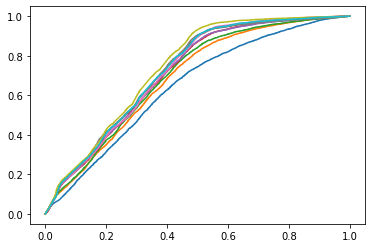

In [85]:
attacks = 10
scores = []
history = []
target_model = None
d_epochs = 2

# train once to get the best model, then train 2 epochs a time to overfit. Attack each time

for attack_i in range(attacks):
  if target_model is None:
    target_model, h = f_target(train_images, train_labels, epochs=100)
  else:
    h = target_model.fit(train_images, train_labels, epochs=d_epochs, validation_split=0.2)
  
  history.append(h)

  attack.target_model = target_model
  attack.target_dataset = train_images, train_labels
  _score = attack.evaluate_attack()
  scores.append(_score)



In [96]:
epochs = 2*np.arange(attacks+1)[1:]


Text(0, 0.5, 'AUC Score')

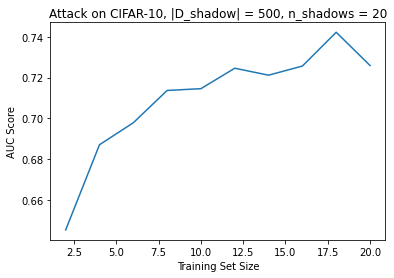

In [97]:
auc_scores = [items[1] for items in scores]

plt.plot(epochs, auc_scores)
plt.title(f'Attack on CIFAR-10, |D_shadow| = {D_SHADOW}, n_shadows = {N_SHADOWS}')
plt.xlabel('Training Set Size')
plt.ylabel('AUC Score')

Text(0, 0.5, 'Recall Score')

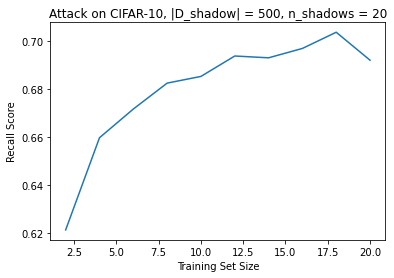

In [98]:
recall_scores = [items[0]['macro avg']['recall'] for items in scores]

plt.plot(epochs, recall_scores)
plt.title(f'Attack on CIFAR-10, |D_shadow| = {D_SHADOW}, n_shadows = {N_SHADOWS}')
plt.xlabel('Training Set Size')
plt.ylabel('Recall Score')

Text(0, 0.5, 'Precision Score')

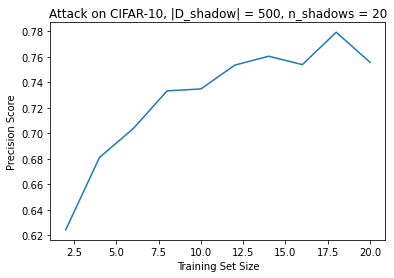

In [99]:
precision_scores = [items[0]['macro avg']['precision'] for items in scores]

plt.plot(epochs, precision_scores)

plt.title(f'Attack on CIFAR-10, |D_shadow| = {D_SHADOW}, n_shadows = {N_SHADOWS}')
plt.xlabel('epochs')
plt.ylabel('Precision Score')

Text(0, 0.5, 'Accuracy Score')

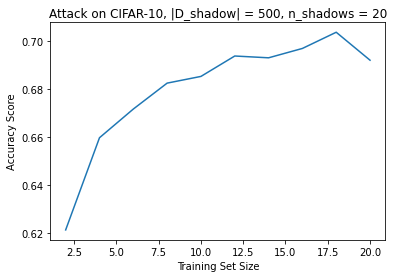

In [100]:
accuracy_scores = [items[0]['accuracy'] for items in scores]

plt.plot(epochs, accuracy_scores)

plt.title(f'Attack on CIFAR-10, |D_shadow| = {D_SHADOW}, n_shadows = {N_SHADOWS}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')

Concat all the histories from model training.

In [118]:
loss = [item for h in history for item in h.history['loss']]
val_loss = [item for h in history for item in h.history['val_loss']]
epochs = np.arange(len(loss)+1)[1:]

acc = [item for h in history for item in h.history['accuracy']]
val_acc = [item for h in history for item in h.history['val_accuracy']]


Text(0.5, 1.0, 'Target model- CIFAR-10 - Training Curve - Loss')

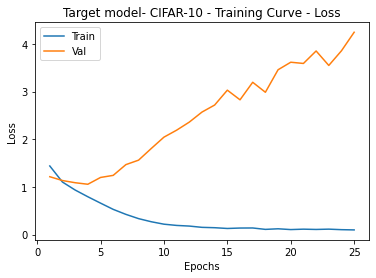

In [128]:
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(["Train", "Val"])
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title('Target model- CIFAR-10 - Training Curve - Loss')

Text(0.5, 1.0, 'Target model- CIFAR-10 - Training Curve - Accuracy')

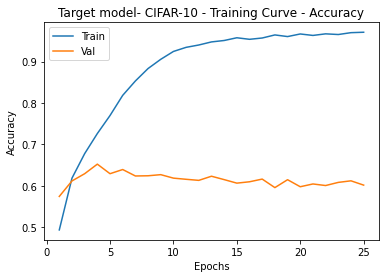

In [127]:
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.legend(["Train", "Val"])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title('Target model- CIFAR-10 - Training Curve - Accuracy')